<a href="https://colab.research.google.com/github/lucckkas/TallerIntegrado/blob/main/Unidad3ProductoComputacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Descripción del Dataset MHEALTH

El dataset MHEALTH (Mobile Health) contiene registros sincronizados de movimiento corporal y señales vitales de 10 voluntarios mientras ejecutan 12 actividades físicas definidas. Su propósito es servir como benchmark para tareas de reconocimiento de actividad humana (HAR) y análisis multimodal de series temporales.

### Resumen Estructural
- Sujetos: 10  
- Actividades: 12  
- Dispositivos: 3 (pecho, muñeca derecha, tobillo izquierdo)  
- Frecuencia de muestreo: 50 Hz en todos los canales  
- Modalidades: Acelerómetro (3 ejes), Giroscopio (3 ejes), Magnetómetro (3 ejes) en cada ubicación + ECG de 2 derivaciones en el sensor del pecho  
- Total de canales crudos principales presentes en este notebook: 23 señales continuas + etiqueta de actividad + ID de sujeto + nombre de actividad (derivado)  

### Actividades (Protocolo)
Cada sujeto ejecuta el siguiente conjunto (códigos 1–12 en la fuente, aquí mapeados si aplica):
1. Standing still (1 min)  
2. Sitting and relaxing (1 min)  
3. Lying down (1 min)  
4. Walking (1 min)  
5. Climbing stairs (1 min)  
6. Waist bends forward (20 repeticiones)  
7. Frontal elevation of arms (20 repeticiones)  
8. Knees bending (crouching) (20 repeticiones)  
9. Cycling (1 min)  
10. Jogging (1 min)  
11. Running (1 min)  
12. Jump front & back (20 repeticiones)  

En este notebook el diccionario ACTIVITY_MAP incluye además la etiqueta 0 (null) para segmentos sin actividad válida.

### Sensores y Señales
Ubicaciones:
1. Pecho: acelerómetro, giroscopio, magnetómetro, ECG (2 derivaciones)  
2. Muñeca derecha: acelerómetro, giroscopio  
3. Tobillo izquierdo: acelerómetro, giroscopio  

El magnetómetro registrado corresponde a la unidad del pecho. Las columnas se encuentran ya estandarizadas según el esquema proporcionado en COLUMN_NAMES.


# Obtain: Descarga del Dataset

In [ ]:
import os
import zipfile
import re
import urllib.request
from pathlib import Path

import pandas as pd

DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
DATA_DIR = Path("data/mhealth")            # Carpeta destino local
ZIP_PATH = DATA_DIR / "MHEALTHDATASET.zip"  # Ruta del zip descargado
RAW_DIR = DATA_DIR / "MHEALTHDATASET"       # Carpeta que contiene los .log

# Columnas según la documentación (23 señales + etiqueta de actividad)
COLUMN_NAMES = [
    'chest_acc_x','chest_acc_y','chest_acc_z',
    'chest_gyro_x','chest_gyro_y','chest_gyro_z',
    'chest_mag_x','chest_mag_y','chest_mag_z',
    'chest_ecg_1','chest_ecg_2',
    'right_wrist_acc_x','right_wrist_acc_y','right_wrist_acc_z',
    'right_wrist_gyro_x','right_wrist_gyro_y','right_wrist_gyro_z',
    'left_ankle_acc_x','left_ankle_acc_y','left_ankle_acc_z',
    'left_ankle_gyro_x','left_ankle_gyro_y','left_ankle_gyro_z',
    'activity'
]

# Mapeo de actividades (incluye 0 = segmento no válido / transición)
ACTIVITY_MAP = {
    0: 'No definida / Transición',
    1: 'Quieto de pie',
    2: 'Sentado relajado',
    3: 'Acostado',
    4: 'Caminando',
    5: 'Subiendo escaleras',
    6: 'Flexión de cintura',
    7: 'Elevación frontal de brazos',
    8: 'Flexión de rodillas (crouching)',
    9: 'Ciclismo',
    10: 'Trote',
    11: 'Corriendo',
    12: 'Saltos adelante/atrás'
}

os.makedirs(DATA_DIR, exist_ok=True)

def download_dataset():
    if RAW_DIR.exists() and any(RAW_DIR.glob("mHealth_subject*.log")):
        print("Dataset ya presente. Se omite descarga.")
        return
    if not ZIP_PATH.exists():
        print("Descargando dataset MHEALTH ...")
        urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
        print("\nDescarga completa.")
    else:
        print("Archivo ZIP ya existe. Saltando descarga.")

    if not RAW_DIR.exists():
        print("Descomprimiendo...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as z:
            z.extractall(DATA_DIR)
        print("Listo.")
    else:
        print("Carpeta descomprimida ya presente.")


def load_all_subjects(sample_fraction: float | None = None) -> pd.DataFrame:
    """Lee todos los archivos mHealth_subjectX.log y construye un DataFrame.
    Parámetros:
        sample_fraction: si se indica (0<fr<=1), toma una fracción aleatoria para pruebas rápidas.
    """
    logs = sorted(RAW_DIR.glob("mHealth_subject*.log"))
    if not logs:
        raise FileNotFoundError("No se encontraron archivos de sujetos en la carpeta RAW. Verifique la descarga.")

    dfs = []
    pattern = re.compile(r"mHealth_subject(\d+)\.log")
    for path in logs:
        match = pattern.search(path.name)
        subject_id = int(match.group(1)) if match else None
        df = pd.read_csv(
            path,
            sep='\\s+',
            header=None,
            names=COLUMN_NAMES,
            dtype='float32',
            engine='python'
        )
        # Convertir actividad a int
        df['activity'] = df['activity'].astype('int16')
        df['subject'] = subject_id
        dfs.append(df)

    full = pd.concat(dfs, ignore_index=True)
    full['activity_name'] = full['activity'].map(ACTIVITY_MAP).astype('category')
    full['subject'] = full['subject'].astype('int8')

    if sample_fraction is not None:
        full = full.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
        print(f"Muestreo aplicado: {sample_fraction*100:.1f}% de los registros")

    return full


download_dataset()
mhealth_df = load_all_subjects(sample_fraction=None)

print("Resumen inicial:")
print("Filas:", len(mhealth_df), "| Columnas:", mhealth_df.shape[1])
print("Columnas:", list(mhealth_df.columns))
print("Actividades presentes (top):")
print(mhealth_df['activity_name'].value_counts())
print()
print("Ejemplo de registros:")
display(mhealth_df.sample(10))


Dataset ya presente. Se omite descarga.
Resumen inicial:
Filas: 1215745 | Columnas: 26
Columnas: ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'chest_ecg_1', 'chest_ecg_2', 'right_wrist_acc_x', 'right_wrist_acc_y', 'right_wrist_acc_z', 'right_wrist_gyro_x', 'right_wrist_gyro_y', 'right_wrist_gyro_z', 'left_ankle_acc_x', 'left_ankle_acc_y', 'left_ankle_acc_z', 'left_ankle_gyro_x', 'left_ankle_gyro_y', 'left_ankle_gyro_z', 'activity', 'subject', 'activity_name']
Actividades presentes (top):
activity_name
No definida / Transición           872550
Caminando                           30720
Ciclismo                            30720
Corriendo                           30720
Acostado                            30720
Trote                               30720
Quieto de pie                       30720
Subiendo escaleras                  30720
Sentado relajado                    30720
Elevación frontal de 

,chest_acc_x,chest_acc_y,chest_acc_z,chest_gyro_x,chest_gyro_y,chest_gyro_z,chest_mag_x,chest_mag_y,chest_mag_z,chest_ecg_1,...,right_wrist_gyro_z,left_ankle_acc_x,left_ankle_acc_y,left_ankle_acc_z,left_ankle_gyro_x,left_ankle_gyro_y,left_ankle_gyro_z,activity,subject,activity_name
421262,-10.7860,0.39232,-0.52259,-0.138150,-0.041863,0.381690,-9.4834,2.15460,-0.289420,-0.63415,...,1.91990,-0.839220,-0.55236,0.390090,-0.895280,0.238150,-13.378000,0,3,No definida / Transición
612526,-9.6653,-0.57235,-0.91467,-0.694920,0.041863,-0.491930,-9.5998,1.41090,-0.725420,-0.75047,...,1.25520,-0.160780,-0.98152,-0.508620,2.152700,-0.173690,2.932900,0,4,No definida / Transición
1125057,-9.5793,-1.84160,-0.16574,-0.129770,0.008373,1.418700,-9.8176,0.41914,0.458260,-0.72233,...,1.43110,0.394120,-1.06370,-0.094828,0.897580,-0.008795,0.018040,0,9,No definida / Transición
167663,-12.1210,1.00290,-4.33080,0.075353,0.062794,0.202270,-11.4800,-1.45740,-0.085343,-0.96435,...,0.54010,-0.592160,-1.01440,0.254310,-5.186500,2.000100,-4.816900,5,10,Subiendo escaleras
874495,-11.0450,-0.75675,-3.04710,-0.196760,-0.096285,7.466500,-5.7901,5.14970,-0.489800,-0.06379,...,3.14300,0.484310,-0.74333,-0.614220,29.521999,-28.075001,107.730003,0,7,No definida / Transición
806713,-9.6781,-0.94105,-0.42154,0.389320,-0.217690,2.472800,-9.4844,1.06090,-0.089054,-0.85553,...,1.53530,0.035294,-1.03080,-0.364220,-3.314900,-8.333200,-1.788000,0,6,No definida / Transición
242707,-3.2589,2.84260,-0.64943,0.456310,0.305600,-6.122900,-19.1530,10.39800,0.541740,-0.72233,...,0.37235,-0.735290,-0.13347,0.831900,-14.086000,-8.272300,84.278000,11,10,Corriendo
173012,-11.0220,0.59370,-3.72550,0.226060,0.184200,-0.067203,-12.0640,-1.43720,0.556590,-0.68105,...,-1.26380,0.678430,-0.96715,0.040948,14.168000,-19.500000,42.355999,0,10,No definida / Transición
192215,-9.6996,0.13290,-1.77750,-0.125590,-0.121400,0.465640,-9.7714,1.07860,-0.198520,-0.73546,...,-0.40870,-0.858820,-0.67146,0.157330,0.540360,0.176180,0.009046,1,10,Quieto de pie
219903,-5.5465,5.60870,-8.84260,-0.041863,-0.050235,-2.366500,-7.9693,-5.83880,0.168830,-0.39024,...,0.82666,0.531370,-1.00410,0.252160,0.046853,4.685300,-3.295000,8,10,Flexión de rodillas (crouching)


# Scrub: Limpiar el dataset

Se decidio eliminar las instancias con actividad de transición (0) del dataset, ya que no aportan información relevante para el análisis de las actividades físicas principales y podrían introducir ruido en los modelos de reconocimiento de actividad humana. Luego se buscan y eliminan filas con valores nulos o duplicados para asegurar la calidad de los datos.

In [ ]:
def limpieza_datos(
    df: pd.DataFrame,
    *,
    activity_col: str = "activity",
    drop_transition_value: int = 0,
    verbose: bool = True
) -> pd.DataFrame:
    if activity_col not in df.columns:
        raise KeyError(f"No se encontró la columna '{activity_col}' requerida para eliminar transiciones.")

    out = df

    # --- 1) Eliminar nulos ---
    null_counts = out.isna().sum()
    total_nulls = int(null_counts.sum())
    rows_before = len(out)
    if total_nulls > 0:
        out = out.dropna()
        if verbose:
            cols_with_nulls = {k:int(v) for k, v in null_counts.items() if v > 0}
            print(f"Nulos eliminados: {rows_before - len(out)} filas | Detalle por columna con NaN: {cols_with_nulls}")
    else:
        if verbose:
            print("No se encontraron valores nulos.")

    # --- 2) Eliminar duplicados exactos ---
    rows_before = len(out)
    out = out.drop_duplicates(keep="first")
    dups_removed = rows_before - len(out)
    if verbose:
        print(f"Duplicados eliminados: {dups_removed} filas")

    # --- 3) Quitar transiciones (activity == drop_transition_value) ---
    rows_before = len(out)
    out = out[out[activity_col] != drop_transition_value].copy()
    transitions_removed = rows_before - len(out)
    if verbose:
        print(f"Transiciones eliminadas (activity == {drop_transition_value}): {transitions_removed}")

    # Mantener índice limpio
    out.reset_index(drop=True, inplace=True)

    # Recalcula nombres de actividad y elimina categorías no usadas
    out['activity_name'] = out['activity_name'].cat.remove_unused_categories()

    if verbose:
        print(f"✅ Limpieza completada. Filas finales: {len(out)} | Columnas: {out.shape[1]}")

    return out


mhealth_clean_basic = limpieza_datos(mhealth_df, activity_col="activity", drop_transition_value=0)


No se encontraron valores nulos.
Duplicados eliminados: 0 filas
Transiciones eliminadas (activity == 0): 872550
✅ Limpieza completada. Filas finales: 343195 | Columnas: 26


En entornos reales, convendria aplicar filtros para suavizar las señales y eliminar ruido, pero en este caso se opta por mantener las señales originales por simplicidad.

# Explore: Análisis exploratorio de datos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def get_sensor_columns(df: pd.DataFrame) -> list[str]:
    drop_cols = {'activity', 'activity_name', 'subject'}
    return [c for c in df.columns if c not in drop_cols]


SENSOR_COLS = get_sensor_columns(mhealth_clean_basic)
SHOW_TABLES = True

In [ ]:
print("=== 1. Resumen general del dataset limpio ===")
print(f"Filas totales: {len(mhealth_clean_basic):,}")
print(f"Columnas disponibles: {list(mhealth_clean_basic.columns)}")
print()
print("Actividades registradas:")
print(mhealth_clean_basic['activity_name'].cat.categories.tolist())
print()
print("Sujetos presentes:")
print(sorted(mhealth_clean_basic['subject'].unique()))
print()
if SHOW_TABLES:
    print("Muestra aleatoria:")
    display(mhealth_clean_basic.sample(5, random_state=7))

=== 1. Resumen general del dataset limpio ===
Filas totales: 343,195
Columnas disponibles: ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'chest_ecg_1', 'chest_ecg_2', 'right_wrist_acc_x', 'right_wrist_acc_y', 'right_wrist_acc_z', 'right_wrist_gyro_x', 'right_wrist_gyro_y', 'right_wrist_gyro_z', 'left_ankle_acc_x', 'left_ankle_acc_y', 'left_ankle_acc_z', 'left_ankle_gyro_x', 'left_ankle_gyro_y', 'left_ankle_gyro_z', 'activity', 'subject', 'activity_name']

Actividades registradas:
['Acostado', 'Caminando', 'Ciclismo', 'Corriendo', 'Elevación frontal de brazos', 'Flexión de cintura', 'Flexión de rodillas (crouching)', 'Quieto de pie', 'Saltos adelante/atrás', 'Sentado relajado', 'Subiendo escaleras', 'Trote']

Sujetos presentes:
[np.int8(1), np.int8(2), np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9), np.int8(10)]

Muestra aleatoria:


,chest_acc_x,chest_acc_y,chest_acc_z,chest_gyro_x,chest_gyro_y,chest_gyro_z,chest_mag_x,chest_mag_y,chest_mag_z,chest_ecg_1,...,right_wrist_gyro_z,left_ankle_acc_x,left_ankle_acc_y,left_ankle_acc_z,left_ankle_gyro_x,left_ankle_gyro_y,left_ankle_gyro_z,activity,subject,activity_name
326700,-8.8684,-1.52720,1.43100,0.431190,0.43537,1.37190,-9.7534,0.90105,0.46197,-0.75797,...,4.32470,0.429410,-0.43737,0.96983,83.952003,-6.958200,-31.103001,7,9,Elevación frontal de brazos
298492,-10.8470,4.44730,-2.04180,0.079540,0.20513,4.06440,-5.6980,-7.42130,0.85158,-0.13696,...,0.78106,-0.066667,-0.81314,0.88578,16.903000,2.667300,29.552999,8,8,Flexión de rodillas (crouching)
297313,-7.9780,1.92940,-0.92109,0.288850,-0.20094,0.75428,-8.7302,-3.71020,0.72356,-0.56473,...,-0.49591,-0.215690,-0.81109,0.79741,-10.594000,-18.110001,-42.991001,8,8,Flexión de rodillas (crouching)
142369,-10.1010,0.99900,-0.91009,-0.376770,0.31397,0.57918,-7.7736,-9.03910,-0.63265,-0.61351,...,2.02450,-0.849020,-0.32649,0.35129,-2.949300,-25.628000,11.389000,5,4,Subiendo escaleras
99447,-11.5260,0.53158,-3.06790,-0.037677,1.35640,-2.86870,-19.2880,-3.09730,0.62523,-0.75610,...,-0.54194,-0.547060,-0.60370,0.79957,-0.097424,62.070999,-199.539993,11,2,Corriendo


=== 2. Distribución de clases (conteo de ventanas crudas por actividad) ===


,count
activity_name,
Acostado,30720
Caminando,30720
Ciclismo,30720
Corriendo,30720
Quieto de pie,30720
Trote,30720
Subiendo escaleras,30720
Sentado relajado,30720
Elevación frontal de brazos,29441


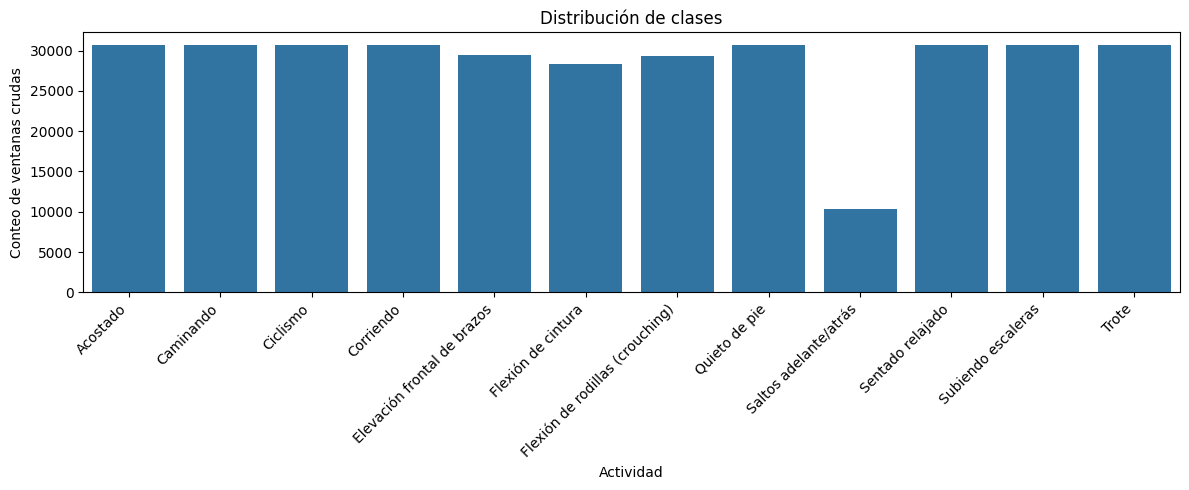

In [ ]:
print("=== 2. Distribución de clases (conteo de ventanas crudas por actividad) ===")
activity_counts = mhealth_clean_basic['activity_name'].value_counts().sort_values(ascending=False)

if SHOW_TABLES:
    display(activity_counts.to_frame(name='count'))

plt.figure(figsize=(12, 5))
sns.barplot(x=activity_counts.index, y=activity_counts.values)
plt.xlabel("Actividad")
plt.ylabel("Conteo de ventanas crudas")
plt.xticks(rotation=45, ha='right')
plt.title("Distribución de clases")
plt.tight_layout()
plt.show()

Aqui podemos ver que la actividad de saltos adelante/atras tiene la menor cantidad de muestras en el dataset limpio, lo que podría afectar la capacidad de los modelos para aprender patrones representativos de esta actividad en particular.

=== 3. Distribución de muestras por sujeto y actividad ===


activity_name,Acostado,Caminando,Ciclismo,Corriendo,Elevación frontal de brazos,Flexión de cintura,Flexión de rodillas (crouching),Quieto de pie,Saltos adelante/atrás,Sentado relajado,Subiendo escaleras,Trote
subject,,,,,,,,,,,,
1,3072,3072,3072,3072,3072,3072,3379,3072,1075,3072,3072,3072
2,3072,3072,3072,3072,3328,3174,3430,3072,1024,3072,3072,3072
3,3072,3072,3072,3072,3379,3226,3175,3072,1024,3072,3072,3072
4,3072,3072,3072,3072,3277,3328,3123,3072,1024,3072,3072,3072
5,3072,3072,3072,3072,2868,2765,2714,3072,1024,3072,3072,3072
6,3072,3072,3072,3072,2099,2202,2304,3072,1024,3072,3072,3072
7,3072,3072,3072,3072,2765,3072,2816,3072,1024,3072,3072,3072
8,3072,3072,3072,3072,3021,2151,2560,3072,1024,3072,3072,3072
9,3072,3072,3072,3072,2867,2867,2969,3072,1075,3072,3072,3072


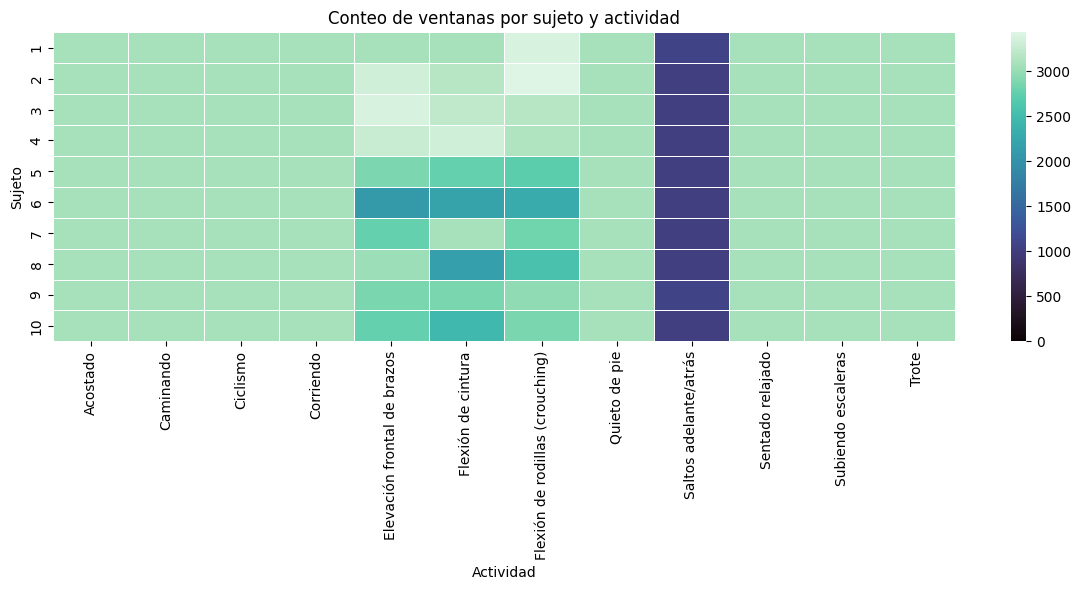

In [ ]:
print("=== 3. Distribución de muestras por sujeto y actividad ===")
ct_subject_activity = pd.crosstab(mhealth_clean_basic['subject'], mhealth_clean_basic['activity_name'])

if SHOW_TABLES:
    display(ct_subject_activity)

plt.figure(figsize=(12, 6))
sns.heatmap(ct_subject_activity, cmap="mako", linewidths=0.5, linecolor="white", vmin=0)
plt.title("Conteo de ventanas por sujeto y actividad")
plt.xlabel("Actividad")
plt.ylabel("Sujeto")
plt.tight_layout()
plt.show()

Aqui podemos ver que todos los sujetos tienen una cantidad similar de muestras en el dataset limpio, lo que sugiere un buen equilibrio en la representación de datos entre los diferentes participantes del estudio.

=== 4. Serie temporal ejemplo por actividad ===
Actividad seleccionada: Caminando | Muestras en segmento: 500


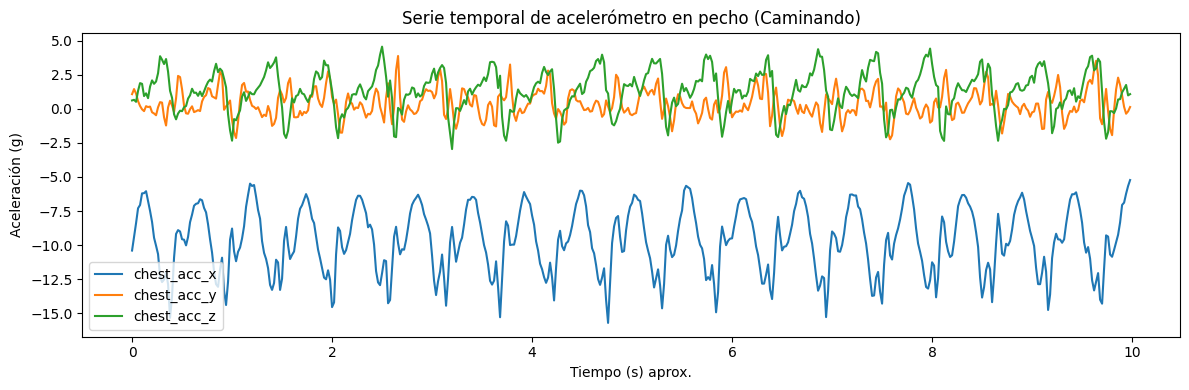

In [ ]:
print("=== 4. Serie temporal ejemplo por actividad ===")

activity = 'Caminando'
subset_activity = mhealth_clean_basic[mhealth_clean_basic['activity_name'] == activity]
segment = subset_activity.head(500).reset_index(drop=True)
signals_to_plot = ['chest_acc_x', 'chest_acc_y', 'chest_acc_z']

print(f"Actividad seleccionada: {activity} | Muestras en segmento: {len(segment)}")

plt.figure(figsize=(12, 4))
for signal in signals_to_plot:
    plt.plot(segment.index / 50, segment[signal], label=signal)
plt.title(f"Serie temporal de acelerómetro en pecho ({activity})")
plt.xlabel("Tiempo (s) aprox.")
plt.ylabel("Aceleración (g)")
plt.legend()
plt.tight_layout()
plt.show()

=== 5. Matriz de correlación de señales seleccionadas ===


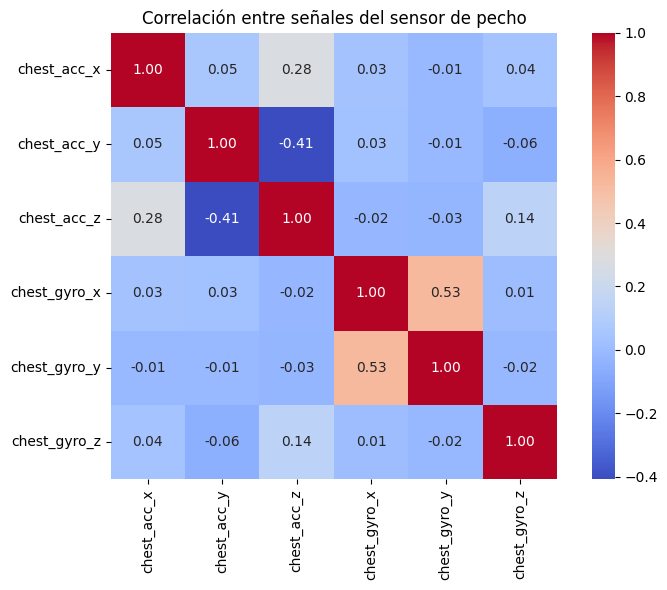

In [ ]:
print("=== 5. Matriz de correlación de señales seleccionadas ===")
available_signals = [
    'chest_acc_x', 'chest_acc_y', 'chest_acc_z',
    'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z'
]

corr_matrix = mhealth_clean_basic[available_signals].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlación entre señales del sensor de pecho")
plt.tight_layout()
plt.show()

Aqui podemos ver que no hay una correlación fuerte entre las señales del acelerómetro en los tres ejes, lo que indica que cada eje captura información distinta sobre el movimiento del sujeto. Esto es beneficioso para el reconocimiento de actividades, ya que proporciona una representación más completa del movimiento corporal.

In [ ]:
print("=== 6. Estadísticas descriptivas por actividad ===")
selected_features = ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z']

stats_by_activity = (
    mhealth_clean_basic
    .groupby('activity_name', observed=False)[selected_features]
    .agg(['mean', 'std'])
)

if SHOW_TABLES:
    display(stats_by_activity.round(3))


=== 6. Estadísticas descriptivas por actividad ===


chest_acc_x         chest_acc_y         \
                                       mean     std        mean    std   
activity_name                                                            
Acostado                              0.324   1.501      -3.317  2.419   
Caminando                            -9.599   2.201      -0.681  1.308   
Ciclismo                             -7.809   1.372       1.518  1.398   
Corriendo                            -7.482  10.168       0.003  5.046   
Elevación frontal de brazos          -9.466   0.463      -0.901  0.793   
Flexión de cintura                   -4.004   4.888       1.947  2.999   
Flexión de rodillas (crouching)      -7.644   2.228       1.232  2.352   
Quieto de pie                        -9.613   0.246      -0.699  0.660   
Saltos adelante/atrás                -5.966  10.754      -0.028  3.267   
Sentado relajado                     -9.303   0.483      -0.314  0.968   
Subiendo escaleras                   -9.394   2.033       0.116  1.455   
Trote                                -8.678   9.292      -0.299  3.370   

                                chest_acc_z        chest_gyro_x         \
                                       mean    std         mean    std   
activity_name                                                            
Acostado                              8.702  1.014       -0.009  0.399   
Caminando                            -0.419  1.881       -0.028  0.448   
Ciclismo                             -5.025  1.194        0.062  0.509   
Corriendo                            -2.481  4.822       -0.142  1.739   
Elevación frontal de brazos           1.353  1.696        0.009  0.638   
Flexión de cintura                   -5.159  3.733        0.002  0.667   
Flexión de rodillas (crouching)      -3.993  3.254        0.037  0.930   
Quieto de pie                         0.141  1.394        0.015  0.464   
Saltos adelante/atrás                -2.158  5.626       -0.067  1.036   
Sentado relajado                      0.104  2.693       -0.014  0.375   
Subiendo escaleras                   -1.541  1.944        0.081  0.815   
Trote                                -1.967  3.483        0.053  1.085   

                                chest_gyro_y        chest_gyro_z         
                                        mean    std         mean    std  
activity_name                                                            
Acostado                              -0.022  0.261        3.992  2.376  
Caminando                             -0.018  0.322        2.033  3.781  
Ciclismo                               0.071  0.397        0.937  1.535  
Corriendo                             -0.204  1.975        3.629  9.174  
Elevación frontal de brazos           -0.004  0.721        1.020  0.913  
Flexión de cintura                     0.013  1.089        0.130  1.213  
Flexión de rodillas (crouching)        0.002  0.907        1.238  1.450  
Quieto de pie                         -0.001  0.318        0.881  0.952  
Saltos adelante/atrás                 -0.078  0.981        1.239  7.998  
Sentado relajado                      -0.020  0.257        1.763  1.201  
Subiendo escaleras                     0.048  0.610        1.594  2.746  
Trote                                  0.074  0.832        2.641  6.500

# 4. Model: Modelado

## 4.1 preprocesamiento de datos

Para la creacion de ventanas se decidio usar ventanas de 8 segundos con un solapamiento del 50%. El solapamiento del 50% ayuda a aumentar la cantidad de datos disponibles para el entrenamiento del modelo, mejorando la capacidad de generalización y reduciendo la pérdida de información entre ventanas consecutivas.

In [ ]:
import numpy as np
from typing import List, Tuple
from collections import Counter

SENSOR_COLS = [
    c for c in mhealth_clean_basic.columns
    if c not in ["activity", "activity_name", "subject"]
]


WINDOW_SIZE = 250  # ~5s
STEP_SIZE   = 125


def make_windows(
    df: pd.DataFrame,
    sensor_cols: List[str],
    window_size: int,
    step_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Genera ventanas deslizantes por SUJETO (no mezcla sujetos).
    Devuelve:
        X_seq: [num_ventanas, window_size, num_features]
        y_seq: [num_ventanas] con la etiqueta mayoritaria en cada ventana
    """
    X_all = []
    y_all = []

    # Importante: groupby('subject') evita mezclar series entre sujetos
    for subject_id, df_subject in df.groupby("subject"):
        data = df_subject[sensor_cols].values    # shape [N, num_features]
        labels = df_subject["activity"].values   # shape [N]

        n = len(df_subject)
        for start in range(0, n - window_size + 1, step_size):
            end = start + window_size

            window_data = data[start:end]        # [window_size, num_features]
            window_labels = labels[start:end]    # [window_size]

            # Etiqueta = mayoría en la ventana
            label = Counter(window_labels).most_common(1)[0][0]

            X_all.append(window_data)
            y_all.append(label)

    X_seq = np.array(X_all, dtype=np.float32)   # [num_ventanas, T, F]
    y_seq = np.array(y_all, dtype=np.int16)     # [num_ventanas]

    return X_seq, y_seq

# -------------------------------------------------
# Feature engineering por ventana
# -------------------------------------------------
def window_to_features(
    X_seq: np.ndarray,
) -> np.ndarray:
    """
    Convierte cada ventana [T, F] en un vector fijo de features estadísticas.
    Para cada feature de cada canal, concatenamos:
    - mean
    - std
    - min
    - max
    - energy (suma de cuadrados)
    - rms (raíz del promedio de cuadrados)
    Devuelve matriz [num_ventanas, num_features_total]
    """
    feats = []

    for x in X_seq:  # x.shape == (window_size, num_raw_features)
        mean_   = x.mean(axis=0)
        std_    = x.std(axis=0, ddof=1)
        min_    = x.min(axis=0)
        max_    = x.max(axis=0)
        energy_ = np.sum(x**2, axis=0)
        rms_    = np.sqrt(np.mean(x**2, axis=0))

        feat_vec = np.concatenate([mean_, std_, min_, max_, energy_, rms_], axis=0)
        feats.append(feat_vec)

    feats = np.array(feats, dtype=np.float32)
    return feats


Por simplicidad y para evitar data leakage, se separa el conjunto de entrenamiento y prueba a nivel de sujetos, asignando 7 sujetos para entrenamiento y 3 para prueba.

In [ ]:
# Split de sujetos (70% train / 30% test)

from sklearn.model_selection import train_test_split

# Sujetos disponibles en el dataset limpio
all_subjects = sorted(mhealth_clean_basic['subject'].unique().tolist())
print("Sujetos totales en el dataset:", all_subjects)

# Split aleatorio y reproducible
train_subjects, test_subjects = train_test_split(
    all_subjects,
    test_size=0.30,
    random_state=42,
    shuffle=True,
)

print("Train subjects:", train_subjects)
print("Test subjects :", test_subjects)

# Filtrar data frame según los sujetos
df_train = mhealth_clean_basic[mhealth_clean_basic["subject"].isin(train_subjects)].copy()
df_test  = mhealth_clean_basic[mhealth_clean_basic["subject"].isin(test_subjects)].copy()

print(f"Filas train: {len(df_train)}")
print(f"Filas test : {len(df_test)}")


Sujetos totales en el dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Train subjects: [1, 8, 3, 10, 5, 4, 7]
Test subjects : [9, 2, 6]
Filas train: 241104
Filas test : 102091


In [ ]:
X_train_seq, y_train = make_windows(
    df_train,
    SENSOR_COLS,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE
)

X_test_seq, y_test = make_windows(
    df_test,
    SENSOR_COLS,
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE
)

print("X_train_seq shape:", X_train_seq.shape)  # [num_win_train, T, F]
print("y_train shape     :", y_train.shape)
print("X_test_seq shape :", X_test_seq.shape)
print("y_test shape     :", y_test.shape)

# --- Features estadísticas por ventana ---
X_train_feat = window_to_features(X_train_seq)  # [num_win_train, D]
X_test_feat  = window_to_features(X_test_seq)   # [num_win_test, D]

print("X_train_feat shape:", X_train_feat.shape)
print("X_test_feat shape :", X_test_feat.shape)

# Chequeo rápido de NaN o inf (debería ser 0 si todo bien)
def check_numeric_sanity(X: np.ndarray, name: str):
    if not np.isfinite(X).all():
        raise ValueError(f"{name} contiene NaN/inf, revisar feature engineering.")
    else:
        print(f"{name} OK (sin NaN/inf)")

check_numeric_sanity(X_train_feat, "X_train_feat")
check_numeric_sanity(X_test_feat,  "X_test_feat")


X_train_seq shape: (1919, 250, 23)
y_train shape     : (1919,)
X_test_seq shape : (812, 250, 23)
y_test shape     : (812,)
X_train_feat shape: (1919, 138)
X_test_feat shape : (812, 138)
X_train_feat OK (sin NaN/inf)
X_test_feat OK (sin NaN/inf)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Z-score normalization
scaler.fit(X_train_feat)

X_train_scaled = scaler.transform(X_train_feat)
X_test_scaled  = scaler.transform(X_test_feat)


## 4.2 Entrenamiento y evaluación de modelos

In [ ]:

from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# --------------------------------------------------------------
# LightGBM (modelo de árboles boosting)
# - No requiere features escaladas
# - Maneja bien features con distintas escalas
# - class_weight='balanced' ayuda con clases desbalanceadas
# --------------------------------------------------------------
lgbm_clf = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    num_leaves=31,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)
lgbm_clf.fit(X_train_feat, y_train)

# --------------------------------------------------------------
# SVM con kernel RBF
# - Necesita features escaladas
# - class_weight='balanced' por si hay actividades con pocas muestras
# --------------------------------------------------------------
svm_clf = SVC(
    kernel='rbf',
    gamma='scale',
    C=1.0,
    class_weight='balanced',
    random_state=42
)
svm_clf.fit(X_train_scaled, y_train)

print("✅ Entrenamiento terminado para LightGBM y SVM.")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35158
[LightGBM] [Info] Number of data points in the train set: 1919, number of used features: 138
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, bes

=== LightGBM ===
Accuracy : 0.9618
Precision: 0.9661
Recall   : 0.9498
F1       : 0.9559

=== SVM (RBF) ===
Accuracy : 0.9335
Precision: 0.9446
Recall   : 0.9201
F1       : 0.9237



d:\Escritorio\TallerIntegrado\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


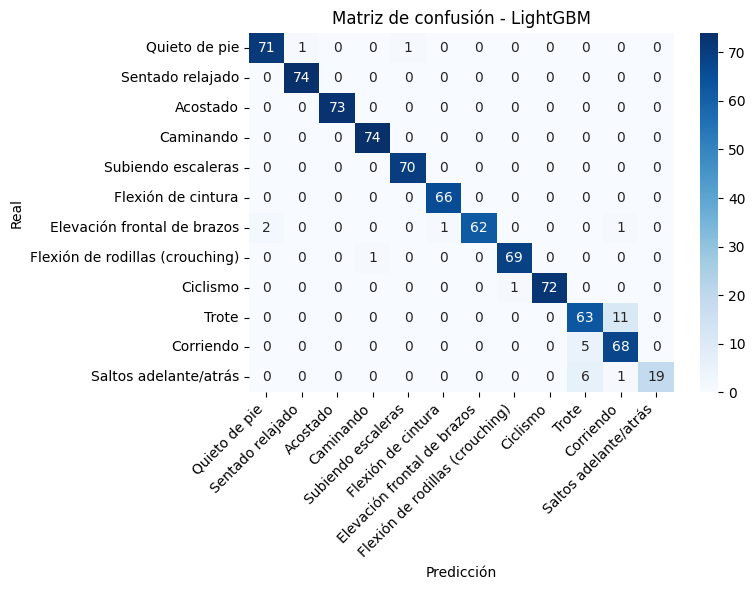

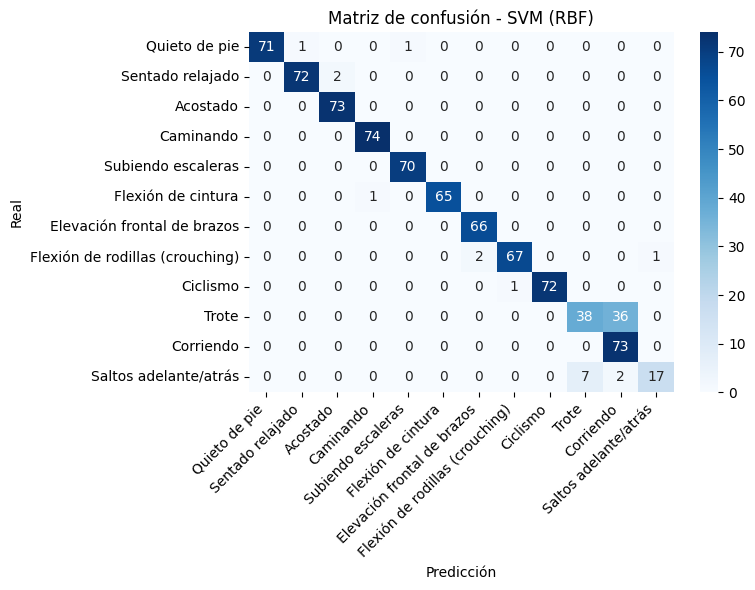

In [ ]:
# ==============================================================
# BLOQUE 6: Evaluación de modelos
# ==============================================================

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
# Predicciones
# --------------------------------------------------------------
y_pred_lgbm = lgbm_clf.predict(X_test_feat)
y_pred_svm  = svm_clf.predict(X_test_scaled)

# --------------------------------------------------------------
# Métricas globales
# --------------------------------------------------------------
def eval_model(y_true, y_pred, model_name: str):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1m = f1_score(y_true, y_pred, average='macro')
    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1m:.4f}")
    print()

eval_model(y_test, y_pred_lgbm, "LightGBM")
eval_model(y_test, y_pred_svm,  "SVM (RBF)")

# --------------------------------------------------------------
# Reporte detallado por clase (precision/recall/F1 por actividad)
# --------------------------------------------------------------
labels_sorted = np.sort(np.unique(y_test))

target_names = [
    ACTIVITY_MAP[int(lbl)] if int(lbl) in ACTIVITY_MAP else f"act_{int(lbl)}"
    for lbl in labels_sorted
]

# --------------------------------------------------------------
# Matriz de confusión
# --------------------------------------------------------------
def plot_conf_matrix(y_true, y_pred, model_name: str):
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap='Blues',
        xticklabels=target_names,
        yticklabels=target_names
    )
    plt.title(f"Matriz de confusión - {model_name}")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_test, y_pred_lgbm, "LightGBM")
plot_conf_matrix(y_test, y_pred_svm,  "SVM (RBF)")


## 4.3 Visualización de resultados

In [ ]:

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average='macro'),
        "precision_macro": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average='macro', zero_division=0),
    }

metrics_lgbm = compute_metrics(y_test, y_pred_lgbm)
metrics_svm  = compute_metrics(y_test, y_pred_svm)

summary_df = pd.DataFrame(
    [metrics_lgbm, metrics_svm],
    index=["LightGBM", "SVM (RBF)"]
)

# Formateo bonito
summary_df = summary_df.round(4)
display(summary_df)



,accuracy,f1_macro,precision_macro,recall_macro
LightGBM,0.9618,0.9559,0.9661,0.9498
SVM (RBF),0.9335,0.9237,0.9446,0.9201


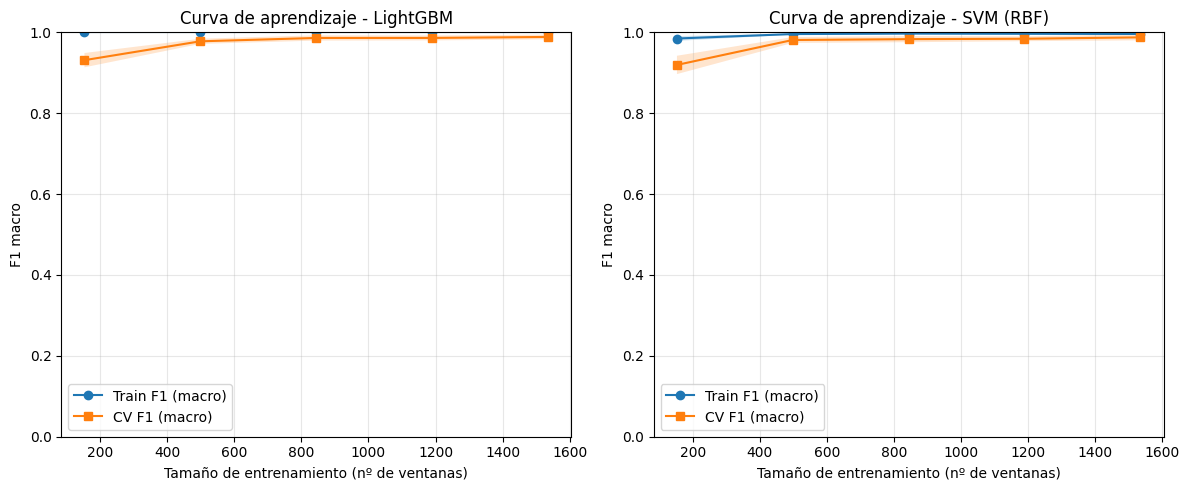

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve
from sklearn.base import clone

# Configuración común
cv_splitter = StratifiedShuffleSplit(
    n_splits=5,
    test_size=0.2,
    random_state=42
)

train_sizes_fraction = np.linspace(0.1, 1.0, 5)  # 10%, 32.5%, 55%, 77.5%, 100%

def compute_learning_curve(estimator, X, y, model_name: str):
    """
    Devuelve tamaños de train y puntajes promedio (train y validación) para curva de aprendizaje.
    """
    est = clone(estimator)

    train_sizes_abs, train_scores, val_scores = learning_curve(
        est,
        X,
        y,
        cv=cv_splitter,
        scoring='f1_macro',
        train_sizes=train_sizes_fraction,
        n_jobs=-1,
        shuffle=True,
        random_state=42  # nota: algunos sklearn ignoran esto, pero ayuda en versiones recientes
    )

    # Promedio y desvío sobre los splits
    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    return train_sizes_abs, train_mean, train_std, val_mean, val_std


# ---- Curva LightGBM (usa features sin escalar)
lgbm_train_sizes, lgbm_train_mean, lgbm_train_std, lgbm_val_mean, lgbm_val_std = compute_learning_curve(
    lgbm_clf,
    X_train_feat,
    y_train,
    "LightGBM"
)

# ---- Curva SVM (usa features escaladas)
svm_train_sizes, svm_train_mean, svm_train_std, svm_val_mean, svm_val_std = compute_learning_curve(
    svm_clf,
    X_train_scaled,
    y_train,
    "SVM (RBF)"
)

# ---- Plot ambas curvas en la misma figura (dos subplots separados)
plt.figure(figsize=(12,5))

# Subplot 1: LightGBM
plt.subplot(1,2,1)
plt.plot(lgbm_train_sizes, lgbm_train_mean, marker='o', label='Train F1 (macro)')
plt.fill_between(
    lgbm_train_sizes,
    lgbm_train_mean - lgbm_train_std,
    lgbm_train_mean + lgbm_train_std,
    alpha=0.2
)
plt.plot(lgbm_train_sizes, lgbm_val_mean, marker='s', label='CV F1 (macro)')
plt.fill_between(
    lgbm_train_sizes,
    lgbm_val_mean - lgbm_val_std,
    lgbm_val_mean + lgbm_val_std,
    alpha=0.2
)
plt.title("Curva de aprendizaje - LightGBM")
plt.xlabel("Tamaño de entrenamiento (nº de ventanas)")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)

# Subplot 2: SVM
plt.subplot(1,2,2)
plt.plot(svm_train_sizes, svm_train_mean, marker='o', label='Train F1 (macro)')
plt.fill_between(
    svm_train_sizes,
    svm_train_mean - svm_train_std,
    svm_train_mean + svm_train_std,
    alpha=0.2
)
plt.plot(svm_train_sizes, svm_val_mean, marker='s', label='CV F1 (macro)')
plt.fill_between(
    svm_train_sizes,
    svm_val_mean - svm_val_std,
    svm_val_mean + svm_val_std,
    alpha=0.2
)
plt.title("Curva de aprendizaje - SVM (RBF)")
plt.xlabel("Tamaño de entrenamiento (nº de ventanas)")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


# Interpretación de resultados

## ¿Qué modelo rindió mejor?

**LightGBM** obtuvo el mejor desempeño global en las cuatro métricas:

- **Accuracy:** 0.9618 (vs. 0.9335 de SVM)
- **F1 macro:** 0.9559 (vs. 0.9237)
- **Precision macro:** 0.9661 (vs. 0.9446)
- **Recall macro:** 0.9498 (vs. 0.9201)

Además, en las **curvas de aprendizaje** ambas líneas (entrenamiento y validación) de LightGBM convergen rápido hacia valores cercanos a 1, con **brecha mínima** entre ambas. Esto indica **buena capacidad de generalización** sin señales claras de sobreajuste. En SVM la brecha inicial es algo mayor con poco dato y converge a valores altos.

En las **matrices de confusión**, LightGBM muestra diagonales más “limpias” y menos confusiones sistemáticas. Un punto crítico donde se ve la diferencia es:

- **“Trote” vs “Ciclismo”**:  
  - **SVM (RBF):** reparte esta clase casi a la mitad (p. ej., 38/36), indicando dificultad para separar los patrones.  
  - **LightGBM:** confunde menos (p. ej., 63 correctos en “Trote” y ~11 en “Ciclismo”), lo que sugiere que los umbrales y combinaciones de features del boosting capturan mejor las diferencias entre ambas actividades.

### ¿Por qué LightGBM supera a SVM (RBF) en este setup?

1. **Naturaleza de las features:** usamos **estadísticos por ventana** (media, std, min, max, energía, RMS) sobre múltiples canales. Estos generan patrones **no lineales y con interacciones** que los árboles potenciados explotan muy bien mediante **cortes y combinaciones de variables** (feature interactions) sin requerir escalado.
2. **Robustez a la escala y a outliers moderados:** LightGBM no necesita normalización y es menos sensible a rangos heterogéneos entre sensores/estadísticos. SVM, aun escalado, puede sufrir si ciertas combinaciones de features requieren fronteras muy complejas.
3. **Imbalance y márgenes:** con `class_weight='balanced'`, LightGBM maneja razonablemente desbalances. En “trote” vs “ciclismo”, donde las distribuciones se parecen, los **conjuntos de reglas** de LightGBM parecen más expresivos que el kernel RBF con los hiperparámetros actuales.

---

## Análisis de errores

A partir de las matrices de confusión:

- **Trote ↔ Ciclismo:** principal foco de confusión, especialmente en SVM. Esto es esperable: ambas actividades son **cíclicas** y comparten energía y ritmos en acelerometría; si el placement de sensores o las condiciones (superficie, cadencia) son similares, los estadísticos en el dominio temporal pueden no ser suficientes para separarlas con claridad.
- **Saltos adelante/atrás:** se observan **falsos positivos hacia “Trote”** (y alguno menor hacia “Ciclismo”). La señal de “saltos” contiene ráfagas de alta energía que, si la ventana coincide con una fase concreta, puede parecerse a tramos de trote.
- **Movimientos de tren superior:** hay **pequeñas confusiones** entre “Elevación frontal de brazos” y “Flexión de cintura”, probablemente por **coactivación y acoplamiento** entre tronco y brazos; dependiendo del sujeto, la flexión puede implicar micro-ajustes en brazos/hombros.

---

## Oportunidades de mejora

1. **Validación más dura tipo LOSO** (*Leave-One-Subject-Out*):  
   Ya separamos por sujeto, pero una validación LOSO (iterar dejando 1 sujeto fuera como test y entrenar con el resto) provee una **estimación más estable y realista** de generalización a usuarios nuevos.
2. **Tuning de hiperparámetros**:
   - **LightGBM**: explorar `num_leaves`, `min_data_in_leaf`, `feature_fraction`, `bagging_fraction`, `lambda_l1/l2`, `learning_rate` y `n_estimators`. Incorporar **early stopping** con un set de validación para evitar sobreajuste.
   - **SVM (RBF)**: barrer sistemáticamente **C** y **gamma** (grid o bayesiano). Probar **SVM lineal** como baseline y **RBF** con regularización más fuerte si hay ruido.
3. **Selección/regularización de features**:
   - Quitar **columnas casi constantes** o altamente colineales para simplificar la frontera de SVM y evitar ruido.
   - Probar **mutual information**, **ANOVA** o **model-based selection** (importancias de LightGBM) para quedarnos con el subconjunto más informativo.
4. **Manejo del desbalance**:
   - Mantener `class_weight='balanced'` y, si es necesario, aplicar **reweighting por clase** específico (p. ej., penalizar más “Trote” vs “Ciclismo”) o **undersampling** leve de clases dominantes.
5. **Robustez a outliers y variabilidad entre sujetos**:
   - Para SVM/KNN (si se reintrodujera), considerar **RobustScaler**.
   - Evaluar **normalización por sujeto** en la etapa de *deep learning* (si se agrega un LSTM/CNN), y comparar contra el enfoque actual basado en features.

---

## Conclusión

- **LightGBM** es el **mejor modelo** en este problema HAR con las features actuales: **mejor F1 macro, precisión y recall**, curvas de aprendizaje estables y menos confusiones sistemáticas (especialmente en **trote vs ciclismo**).  
- **SVM (RBF)** también logra un rendimiento alto, pero requiere tuning adicional y/o features más discriminativas en frecuencia para cerrar la brecha.  
- La principal **fuente de error** proviene de **actividades cíclicas** con patrones semejantes; la **ampliación a features espectrales y de correlación**, más **validación LOSO** y **tuning dirigido**, son los pasos con mayor retorno esperado para seguir elevando el desempeño y la robustez del sistema.
